In [72]:
# ======================
# 0. CONFIG
# ======================
import os
from pathlib import Path

# Path ke model (SAMA dengan backend)
MODEL_PATH = "best_gacor.pth"

# Folder dataset yang mau di-testing
DATASET_DIR = "./dataset2"       # ganti kalau folder beda

# Nama output CSV
OUTPUT_CSV = "jawaban.csv"

# Device
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

print("CWD :", os.getcwd())
print("MODEL_PATH exists? ", os.path.exists(MODEL_PATH))


DEVICE: cpu
CWD : s:\ITERA\If-Semester 7\Deep Learning\tubes
MODEL_PATH exists?  True


In [73]:
# ======================
# 1. IMPORT & MODEL DEF
# ======================
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import csv
import numpy as np
from facenet_pytorch import MTCNN

class ResNet50Embedding(nn.Module):
    def __init__(self, embed_dim=512, p_drop=0.5):
        super(ResNet50Embedding, self).__init__()
        resnet = models.resnet50(weights=None) 

        in_features = resnet.fc.in_features
        resnet.fc = nn.Identity()            

        self.backbone = resnet
        self.bn = nn.BatchNorm1d(in_features)
        self.dropout = nn.Dropout(p_drop)
        self.fc = nn.Linear(in_features, embed_dim) 

    def forward(self, x):
        x = self.backbone(x)   # [B, 2048]
        x = self.bn(x)         # [B, 2048]
        x = self.dropout(x)
        x = self.fc(x)         # [B, 512]
        return x


In [74]:
# ======================
# 2. LOAD MODEL DARI best_gacor.pth
# ======================

def load_model_from_ckpt(ckpt_path, device=DEVICE):
    ckpt = torch.load(ckpt_path, map_location=device)
    print("Checkpoint keys:", ckpt.keys())

    # --- Ambil info kelas ---
    class_to_idx = ckpt.get("class_to_idx", {})
    idx_to_class = ckpt.get("idx_to_class", {})
    num_classes = len(class_to_idx) if class_to_idx else 70

    # Normalisasi idx_to_class → dict idx:int -> label:str
    if isinstance(idx_to_class, list):
        idx_to_class_map = {i: lbl for i, lbl in enumerate(idx_to_class)}
    elif isinstance(idx_to_class, dict) and all(isinstance(k, int) for k in idx_to_class.keys()):
        idx_to_class_map = idx_to_class
    elif isinstance(idx_to_class, dict) and all(isinstance(v, int) for v in idx_to_class.values()):
        # kasus LABEL→INT
        idx_to_class_map = {v: k for k, v in idx_to_class.items()}
    else:
        idx_to_class_map = {i: f"class_{i}" for i in range(num_classes)}

    # --- ukuran gambar dari ckpt (kalau ada) ---
    img_size = ckpt.get("img_size", 224)

    # --- Bangun model embedding dan load state_dict ---
    model = ResNet50Embedding(embed_dim=512, p_drop=0.5)
    model.load_state_dict(ckpt["model"])
    model.to(device).eval()

    # --- Ambil weight ArcFace ---
    arc_state = ckpt["arc"]
    if isinstance(arc_state, dict) and "weight" in arc_state:
        arc_weight = arc_state["weight"]
    else:
        arc_weight = arc_state.weight
    arc_weight = arc_weight.to(device)

    print("✓ ArcFace checkpoint loaded successfully!")
    print(f"  Classes: {num_classes}")
    print(f"  Sample labels: {[idx_to_class_map[i] for i in list(idx_to_class_map.keys())[:5]]} ...")

    return model, arc_weight, idx_to_class_map, img_size


# --- Panggil loader ---
model, arc_weight, idx_to_class_map, IMG_SIZE = load_model_from_ckpt(MODEL_PATH, device=DEVICE)
print("IMG_SIZE:", IMG_SIZE)


Checkpoint keys: dict_keys(['model', 'arc', 'class_to_idx', 'idx_to_class', 'img_size'])
✓ ArcFace checkpoint loaded successfully!
  Classes: 70
  Sample labels: ['abraham ganda napitu', 'abu bakar siddiq siregar', 'ahmad faqih hasani', 'aldi sanjaya', 'alfajar'] ...
IMG_SIZE: 224
✓ ArcFace checkpoint loaded successfully!
  Classes: 70
  Sample labels: ['abraham ganda napitu', 'abu bakar siddiq siregar', 'ahmad faqih hasani', 'aldi sanjaya', 'alfajar'] ...
IMG_SIZE: 224


In [75]:
# ======================
# 3. TRANSFORM INFERENCE
# ======================
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std =[0.5, 0.5, 0.5]),
])


In [ ]:
# ======================
# 4. DATASET TANPA LABEL 
# ======================
from torch.utils.data import Dataset, DataLoader

IMG_EXTENSIONS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp")

class SimpleImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.samples = []

        print(f"Mencari gambar di: {self.root_dir.resolve()}")

        for p in self.root_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTENSIONS:
                self.samples.append(p)

        self.samples = sorted(self.samples)

        print(f"Total file gambar ditemukan: {len(self.samples)}")
        if len(self.samples) == 0:
            print("⚠ PERINGATAN: Tidak ada gambar yang cocok ekstensi di folder tersebut.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path = self.samples[idx]
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            raise RuntimeError(f"Gagal membuka gambar: {path} | error: {e}")

        if self.transform is not None:
            img = self.transform(img)
        return img, str(path)


infer_dataset = SimpleImageDataset(DATASET_DIR, transform=test_transform)

infer_loader = DataLoader(
    infer_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0,  
)

print("Total gambar untuk inference:", len(infer_dataset))


Mencari gambar di: S:\ITERA\If-Semester 7\Deep Learning\tubes\dataset2
Total file gambar ditemukan: 281
Total gambar untuk inference: 281


In [77]:
# ======================
# 5. PREDIKSI BATCH
# ======================

def predict_batch(model, arc_weight, images, device=DEVICE, scale=20.0):
    """
    Sama konsepnya seperti predict_identity di backend:
    emb -> normalize -> matmul ke w_norm -> softmax
    """
    model.eval()
    images = images.to(device)

    with torch.no_grad():
        emb = model(images)                   
        emb_norm = F.normalize(emb, dim=1)
        w_norm   = F.normalize(arc_weight, dim=1)  
        logits   = torch.matmul(emb_norm, w_norm.t()) * scale
        probs    = torch.softmax(logits, dim=1)      

    confs, idxs = probs.max(dim=1)  
    return idxs.cpu(), confs.cpu()


In [ ]:
# ======================
# 6. LOOP INFERENCE
# ======================

rows = []  # untuk CSV

if len(infer_dataset) == 0:
    print("⚠ Dataset kosong, tidak ada gambar untuk diproses.")
else:
    for batch_idx, (imgs, paths) in enumerate(infer_loader):
        print(f"Memproses batch {batch_idx+1} / ~{len(infer_dataset) // 32 + 1}")
        pred_idx, confs = predict_batch(model, arc_weight, imgs, device=DEVICE, scale=20.0)

        for path, idx, conf in zip(paths, pred_idx.tolist(), confs.tolist()):
            label = idx_to_class_map.get(idx, f"class_{idx}")
            filename = os.path.basename(path)
            rows.append({
                "filename": filename,
                "label": label,
                "pred_idx": idx,
                "confidence": float(conf),
            })

    print("Total prediksi:", len(rows))


Memproses batch 1 / ~9
Memproses batch 2 / ~9
Memproses batch 2 / ~9
Memproses batch 3 / ~9
Memproses batch 3 / ~9


In [ ]:
# ======================
# 7. SIMPAN jawaban.csv
# ======================

fieldnames = ["filename", "label"]  

with open(OUTPUT_CSV, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    for r in rows:
        writer.writerow({
            "filename": r["filename"],
            "label": r["label"],
        })

print("jawaban.csv tersimpan di:", os.path.abspath(OUTPUT_CSV))


jawaban.csv tersimpan di: s:\ITERA\If-Semester 7\Deep Learning\tubes\jawaban.csv


In [ ]:
# ======================
# B. BERSIHKAN & JOIN
# ======================

# SESUAIKAN nama kolom di sini dengan yang kelihatan di print di atas
PRED_FILENAME_COL = "filename"
PRED_LABEL_COL    = "label"    # prediksi dari model (isi jawaban.csv)

GT_FILENAME_COL   = "filename"
GT_LABEL_COL      = "label"    # label asli di labels.csv

def clean_name(x):
    return os.path.basename(str(x)).strip().lower()

# bikin kolom 'filename_clean'
df_pred["filename_clean"] = df_pred[PRED_FILENAME_COL].apply(clean_name)
df_gt["filename_clean"]   = df_gt[GT_FILENAME_COL].apply(clean_name)

# bikin kolom label bersih (strip + lower)
df_pred["pred_clean"]  = df_pred[PRED_LABEL_COL].astype(str).str.strip().str.lower()
df_gt["label_clean"]   = df_gt[GT_LABEL_COL].astype(str).str.strip().str.lower()

# join berdasarkan filename_clean
df_merge = df_pred.merge(
    df_gt[["filename_clean", "label_clean"]],
    on="filename_clean",
    how="inner",
)

print("Total baris setelah join:", len(df_merge))
print(df_merge.head())


Total baris setelah join: 278
                          filename                     label  \
0      Abraham Ganda Napitu_1.jpeg      abraham ganda napitu   
1      Abraham Ganda Napitu_2.jpeg      abraham ganda napitu   
2      Abraham Ganda Napitu_3.jpeg      abraham ganda napitu   
3      Abraham Ganda Napitu_4.jpeg      abraham ganda napitu   
4  Abu Bakar Siddiq Siregar_1.jpeg  abu bakar siddiq siregar   

                    filename_clean             label_clean_x  \
0      abraham ganda napitu_1.jpeg      abraham ganda napitu   
1      abraham ganda napitu_2.jpeg      abraham ganda napitu   
2      abraham ganda napitu_3.jpeg      abraham ganda napitu   
3      abraham ganda napitu_4.jpeg      abraham ganda napitu   
4  abu bakar siddiq siregar_1.jpeg  abu bakar siddiq siregar   

                 pred_clean             label_clean_y  
0      abraham ganda napitu      abraham ganda napitu  
1      abraham ganda napitu      abraham ganda napitu  
2      abraham ganda napitu     

In [ ]:
# ======================
# 9. BERSIHKAN NAMA & BIKIN MAPPING GT
# ======================
import os

GT_FILENAME_COL = "filename"   # kolom nama file di labels.csv
GT_LABEL_COL    = "label"      # kolom label asli di labels.csv

def clean_name(x):
    return os.path.basename(str(x)).strip().lower()

df_pred["filename_clean"] = df_pred["filename"].apply(clean_name)
df_gt["filename_clean"]   = df_gt[GT_FILENAME_COL].apply(clean_name)

# label versi bersih
df_pred["pred_clean"]  = df_pred["label"].astype(str).str.strip().str.lower()
df_gt["label_clean"]   = df_gt[GT_LABEL_COL].astype(str).str.strip().str.lower()

gt_map = dict(zip(df_gt["filename_clean"], df_gt["label_clean"]))

print("Contoh gt_map:")
print(list(gt_map.items())[:5])

print("Total pred di jawaban.csv:", len(df_pred))
print("Total GT di labels.csv   :", len(df_gt))


Contoh gt_map:
[('fajrul ramadhana aqsa_1.jpg', 'fajrul ramadhana aqsa'), ('fajrul ramadhana aqsa_2.jpg', 'fajrul ramadhana aqsa'), ('fajrul ramadhana aqsa_3.jpg', 'fajrul ramadhana aqsa'), ('fajrul ramadhana aqsa_4.jpg', 'fajrul ramadhana aqsa'), ('freddy harahap_1.jpg', 'freddy harahap')]
Total pred di jawaban.csv: 278
Total GT di labels.csv   : 278


Total cocok GT+pred: 278
Total prediksi di CSV: 278
Total filename yang tidak ada di labels.csv: 0

Accuracy : 0.9640
F1-macro : 0.9638
Precision: 0.9707
Recall   : 0.9643

Classification Report:
                                 precision    recall  f1-score   support

           abraham ganda napitu       1.00      1.00      1.00         4
       abu bakar siddiq siregar       1.00      1.00      1.00         4
             ahmad faqih hasani       1.00      1.00      1.00         4
                   aldi sanjaya       0.80      1.00      0.89         4
                        alfajar       1.00      1.00      1.00         4
            alief fathur rahman       1.00      1.00      1.00         4
 arkan hariz chandrawinata liem       0.80      1.00      0.89         4
               bayu ega ferdana       1.00      0.75      0.86         4
          bayu prameswara haris       1.00      0.75      0.86         4
           bezalel samuel manik       1.00      1.00      1.00         4


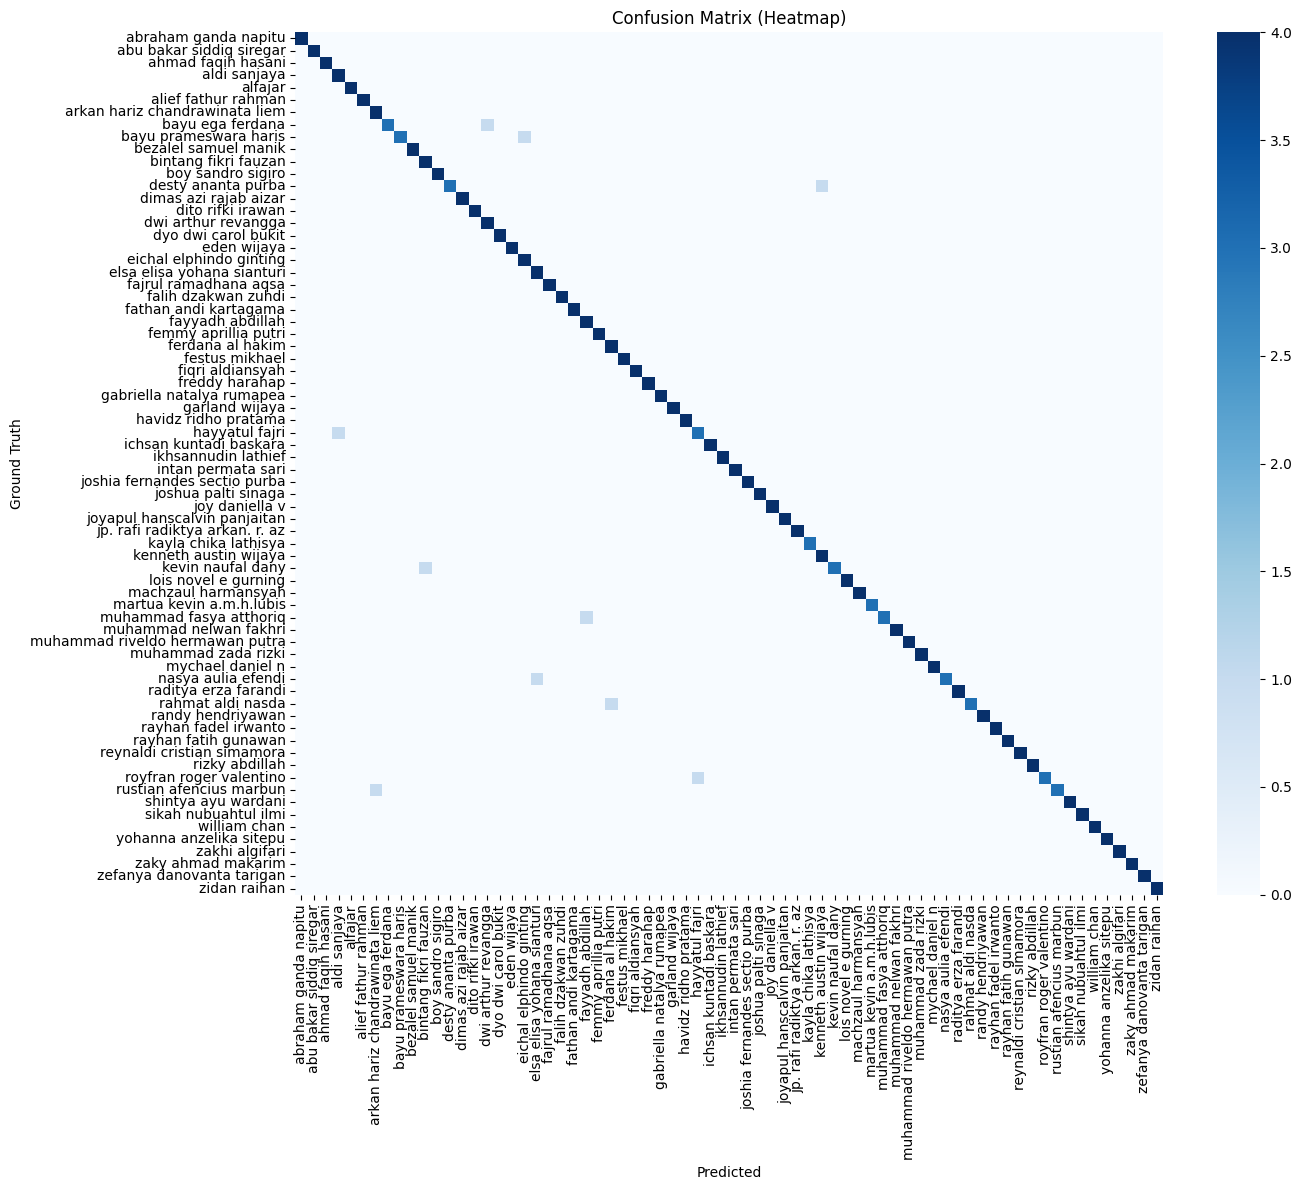

<Figure size 1400x600 with 0 Axes>

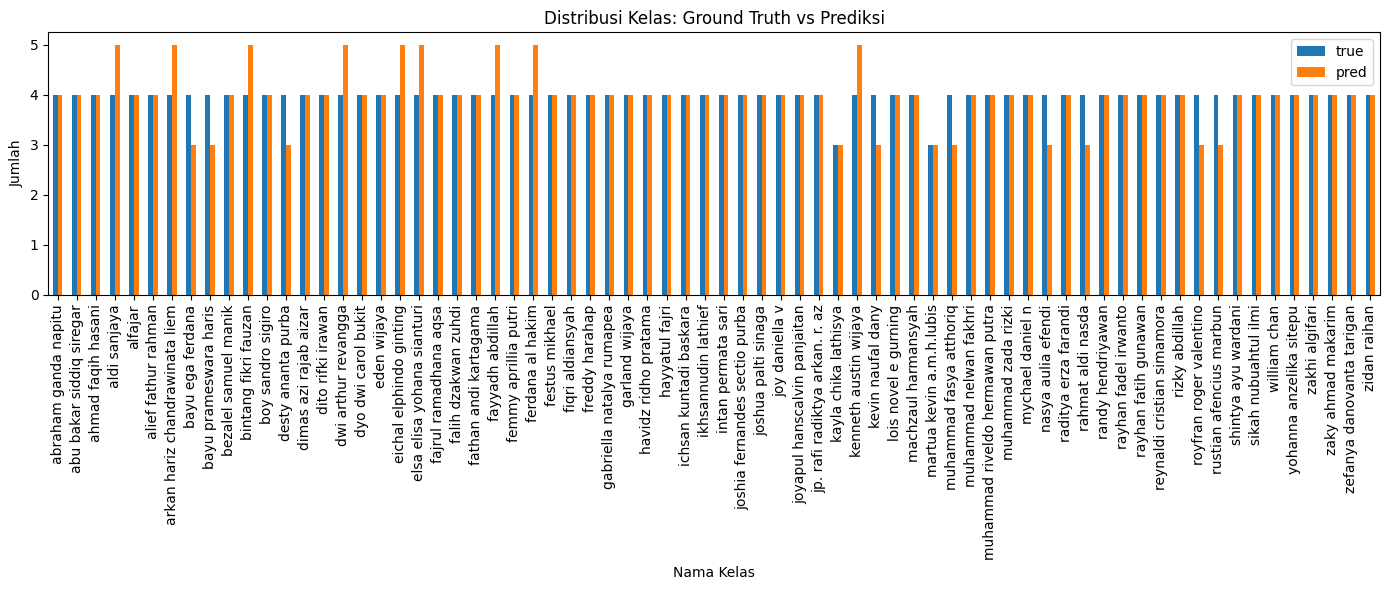

C:\Users\hp\AppData\Local\Temp\ipykernel_30956\2849737359.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=err_count.index, y=err_count.values, palette="Reds_r")


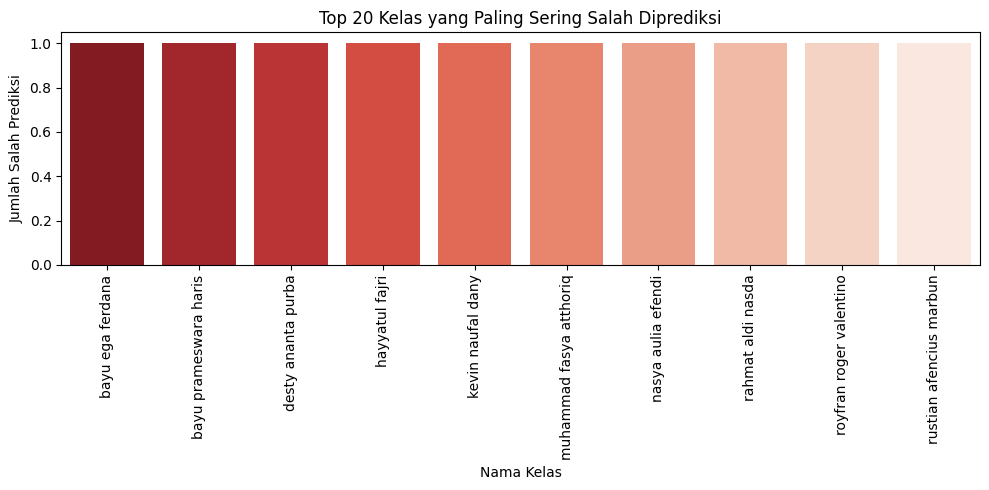

In [ ]:
# ======================
# 10. HITUNG METRIC + PLOT LENGKAP
# ======================
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# ------------------------------
# 1) Hitung metric
# ------------------------------

y_true = []
y_pred = []
missing = []

for _, row in df_pred.iterrows():
    fname_clean = row["filename_clean"]
    pred_label  = row["pred_clean"]

    if fname_clean not in gt_map:
        missing.append(fname_clean)
        continue

    true_label = gt_map[fname_clean]

    y_true.append(true_label)
    y_pred.append(pred_label)

print(f"Total cocok GT+pred: {len(y_true)}")
print(f"Total prediksi di CSV: {len(df_pred)}")
print(f"Total filename yang tidak ada di labels.csv: {len(missing)}")
if missing:
    print("Contoh filename yang tidak ketemu GT:", missing[:10])


if len(y_true) == 0:
    print("⚠ Tidak ada pasangan (pred, GT) yang bisa dibandingkan.")
else:
    acc  = accuracy_score(y_true, y_pred)
    f1   = f1_score(y_true, y_pred, average="macro", zero_division=0)
    prec = precision_score(y_true, y_pred, average="macro", zero_division=0)
    rec  = recall_score(y_true, y_pred, average="macro", zero_division=0)

    print(f"\nAccuracy : {acc:.4f}")
    print(f"F1-macro : {f1:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, zero_division=0))

    # ------------------------------
    # 2) Confusion Matrix Heatmap
    # ------------------------------

    labels_sorted = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels_sorted)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, cmap="Blues",
                xticklabels=labels_sorted, yticklabels=labels_sorted)
    plt.title("Confusion Matrix (Heatmap)")
    plt.xlabel("Predicted")
    plt.ylabel("Ground Truth")
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 3) Jumlah data per kelas (GT vs Pred)
    # ------------------------------

    df_count = pd.DataFrame({
        "true": pd.Series(y_true).value_counts(),
        "pred": pd.Series(y_pred).value_counts()
    }).fillna(0).astype(int)

    df_count_sorted = df_count.sort_index()

    plt.figure(figsize=(14, 6))
    df_count_sorted.plot(kind="bar", figsize=(14,6))
    plt.title("Distribusi Kelas: Ground Truth vs Prediksi")
    plt.ylabel("Jumlah")
    plt.xlabel("Nama Kelas")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # ------------------------------
    # 4) Plot Kesalahan (Misclassifications)
    # ------------------------------

    df_errors = pd.DataFrame({"true": y_true, "pred": y_pred})
    df_errors = df_errors[df_errors["true"] != df_errors["pred"]]

    if len(df_errors) > 0:
        err_count = df_errors["true"].value_counts().head(20)

        plt.figure(figsize=(10, 5))
        sns.barplot(x=err_count.index, y=err_count.values, palette="Reds_r")
        plt.title("Top 20 Kelas yang Paling Sering Salah Diprediksi")
        plt.ylabel("Jumlah Salah Prediksi")
        plt.xlabel("Nama Kelas")
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    else:
        print("Tidak ada misclassification — PERFECT SCORE 😎🔥")


In [ ]:
# ======================
# 11. UPLOAD FILE & TAMPILKAN PREDIKSI (VERSI JELAS)
# ======================
import io
import ipywidgets as widgets
from IPython.display import display, clear_output

# --- Widget ---
uploader = widgets.FileUpload(
    accept='image/*',  # hanya gambar
    multiple=False
)
btn_pred = widgets.Button(
    description="Prediksi",
    button_style='success'
)
output = widgets.Output()

def predict_single_image(pil_img):
    """Prediksi satu gambar PIL, return (label, prob)"""
    model.eval()
    img_t = test_transform(pil_img).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        emb = model(img_t)                    # [1, 512]
        emb_norm = F.normalize(emb, dim=1)
        w_norm   = F.normalize(arc_weight, dim=1)  # [C, 512]
        logits   = torch.matmul(emb_norm, w_norm.t()) * 20.0
        probs    = torch.softmax(logits, dim=1)[0]

        top_prob, top_idx = torch.max(probs, dim=0)
        idx_int = top_idx.item()
        label = idx_to_class_map.get(idx_int, f"class_{idx_int}")
        return label, float(top_prob.item())


def get_uploaded_file():
    """Ambil file dari uploader (support tuple/dict)"""
    files = uploader.value
    if not files:
        return None, None

    # ipywidgets versi baru: tuple of dicts
    # versi lama: dict {name: {content: ...}}
    if isinstance(files, dict):
        # ambil file pertama
        name, info = next(iter(files.items()))
        content = info["content"]
    else:
        # tuple/list of file dicts
        info = files[0]
        name = info.get("name", "uploaded_image")
        content = info["content"]

    return name, content


def on_click_pred(b):
    with output:
        clear_output()
        name, content = get_uploaded_file()
        if content is None:
            print("Belum ada file yang di-upload.")
            return

        try:
            pil_img = Image.open(io.BytesIO(content)).convert("RGB")
        except Exception as e:
            print(f"Gagal membuka gambar: {e}")
            return

        print(f"File di-upload: {name}")
        display(pil_img.resize((256, 256)))

        try:
            label, prob = predict_single_image(pil_img)
            print(f"\nPrediksi kelas : {label}")
            print(f"Probabilitas   : {prob:.3f}")
        except Exception as e:
            print("Terjadi error saat prediksi:")
            print(e)

btn_pred.on_click(on_click_pred)

print("Langkah:")
print("1. Upload 1 file gambar (klik di bawah).")
print("2. Klik tombol 'Prediksi' untuk melihat kelas yang diprediksi.\n")

display(widgets.VBox([uploader, btn_pred, output]))

Langkah:
1. Upload 1 file gambar (klik di bawah).
2. Klik tombol 'Prediksi' untuk melihat kelas yang diprediksi.

